# Independent Project - Milestone 4

### Author - Ana Javed

Project Guidance and Instructions

Milestone 4 is where everything you built in the previous milestones comes together. For this Milestone, you focus on improving model accuracy and summarizing your findings. Try explaining your findings as if you are presenting to your management team in layman’s terms. For example, talk about the influencing factors, what can be improved, what is important in your findings, what is the key aspect to focus on, what do the data tell them that they do not know.

For Milestone 4 you should: 

    - update Milestones 1 through 3, and assignment 9 based on feedback;
    - enhance your model results by trying different model and/or data enhancement techniques (Build 3 models with different enhancements and feature engineering techniques);
    - explain your choice of model and model accuracy; and
    - draw direct inferences and conclusions from model results (describe how your model results can improve or provide a solution to the problem you have chosen). Use graphs and evidence from the data to prove your point. Part of being a data scientist is to tell a story that helps the business.



In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.graphics.tsaplots as splt
import statsmodels.tsa.seasonal as sts
import statsmodels.tsa.arima_process as arima

from statsmodels.tsa.stattools import adfuller
import sklearn.linear_model as lm
import pmdarima as pm
from pmdarima.arima import auto_arima

%matplotlib inline

## Data Source / Background Information:

According to the California Office of Environmental Health Hazard Assessment:(https://oehha.ca.gov/calenviroscreen/indicator/air-quality-pm25) 

"Particulate matter, or PM2.5, is very small particles in air that are 2.5 micrometers (about 1 ten-thousandth of an inch) or less in diameter. This is less than the thickness of a human hair. Particulate matter, one of six U.S. EPA criteria air pollutants, is a mixture that can include organic chemicals, dust, soot and metals. These particles can come from cars and trucks, factories, wood burning, and other activities."

PM2.5 can be examined to help measure the amount of pollution in the air. The dataset that will be analyzed is PM2.5 measurements collected by the US Embassy in Beijing. Details regarding the data can be found here: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data



In [2]:
## Data File URL 
fileName = "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"

## Reading in the CSV filt into pandas data frame 
pollution_df = pd.read_csv(fileName)

## Top and Bottom 15 Rows 
print(pollution_df.head(15))
print("\n")
print(pollution_df.head(15))
print("\n")

## Exploratory Data Analysis 
print(pollution_df.columns) ## Printing Columns 
print("\n")
print(pollution_df.shape) ## Printing Data Dimensions 
print("\n")
print(pollution_df.dtypes) ## Printing Column Types 
print("\n")


    No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0    1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1    2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2    3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3    4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4    5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0
5    6  2010      1    1     5    NaN   -19 -10.0  1017.0   NW  16.10   0   0
6    7  2010      1    1     6    NaN   -19  -9.0  1017.0   NW  19.23   0   0
7    8  2010      1    1     7    NaN   -19  -9.0  1017.0   NW  21.02   0   0
8    9  2010      1    1     8    NaN   -19  -9.0  1017.0   NW  24.15   0   0
9   10  2010      1    1     9    NaN   -20  -8.0  1017.0   NW  27.28   0   0
10  11  2010      1    1    10    NaN   -19  -7.0  1017.0   NW  31.30   0   0
11  12  2010      1    1    11    NaN   -18  -5.0  1017.0   NW  

In [3]:
## Looking For Missing Values in the Columns. Want to Account for the NaN values! 
# pollution_df.loc[:, "pm2.5"].value_counts() # NaN values Present
# pollution_df.loc[:, "year"].value_counts() # none
# pollution_df.loc[:, "month"].value_counts() # none
# pollution_df.loc[:, "day"].value_counts() #none

## Identifying How Many NaNs in the pm2.5 column: 
HasNan1 = np.isnan(pollution_df.loc[:,'pm2.5'])
sum(HasNan1) # 2067 NaNs out of 43824
# pollution_df.loc[HasNan1,'pm2.5'] = np.nanmedian(pollution_df.loc[:,'pm2.5'])

# ## Dropping NaN Values 
pollution_df = pollution_df.dropna() 


## Confirming new Dimensions of the Data Frame: 
print(pollution_df.shape) # now 41757 Rows, 13 Columns 

(41757, 13)


In [4]:
## Scaling Temp, Pres, and Dew Point Columns 
# Declaring Scale function
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

pollution_df.loc[:, "DEWP"] = np.apply_along_axis(scale, 0, pollution_df.loc[:, "DEWP"])
pollution_df.loc[:, "TEMP"] = np.apply_along_axis(scale, 0, pollution_df.loc[:, "TEMP"])
pollution_df.loc[:, "PRES"] = np.apply_along_axis(scale, 0, pollution_df.loc[:, "PRES"])
pollution_df.loc[:, "pm2.5"] = np.apply_along_axis(scale, 0, pollution_df.loc[:, "pm2.5"])

# print(pollution_df.head(15))
# print("\n")
# print(pollution_df.head(15))
# print("\n")


In [5]:
## Converting Year & Month Columns to Datetime Date Column in the Data Frame 
from datetime import datetime

pollution_df.loc[:, "Date"] = pd.to_datetime(pollution_df.loc[:, "year"].astype(str) 
                                             + '-' + pollution_df.loc[:, "month"].astype(str)
                                            )
# New Combined Datetime Column: 
pollution_df.loc[:, "Date"]


## Creating a new column and taking average Of PM2.5 per Month 
pollution_df["avg_pm"] = pollution_df.groupby("Date")["pm2.5"].transform(np.average)

## Creating a new DF of the Monthly Dates & Average PM columns 
pm_df = pollution_df.loc[:, ["Date","avg_pm"]]
pm_df = pm_df.set_index("Date")

## Removing Duplicate Rows 
pm_df = pm_df.drop_duplicates()

## Examining the Shape / Format of the new DF: 
print(pm_df.shape) # (60, 1)
print(pm_df.head(10)) # Data Starts: 2010-01-01 
print(pm_df.tail(10)) # Data Ends: 2014-12-01  

(60, 1)
              avg_pm
Date                
2010-01-01 -0.088764
2010-02-01 -0.014984
2010-03-01 -0.049029
2010-04-01 -0.201891
2010-05-01 -0.127254
2010-06-01  0.112878
2010-07-01  0.271970
2010-08-01 -0.010985
2010-09-01  0.259616
2010-10-01  0.221287
              avg_pm
Date                
2014-03-01  0.128981
2014-04-01 -0.036723
2014-05-01 -0.286352
2014-06-01 -0.429452
2014-07-01 -0.099483
2014-08-01 -0.387515
2014-09-01 -0.307656
2014-10-01  0.455654
2014-11-01  0.062629
2014-12-01 -0.216897


In [6]:
# One-hot encode inputs --> Month and Hour Columns Specifically
pollution_df = pd.get_dummies(pollution_df, columns=['month', 'hour'], drop_first=False,
                             )
print('DataFrame one-hot-expanded shape: {}'.format(pollution_df.shape))


DataFrame one-hot-expanded shape: (41757, 49)


In [7]:
### Binning the Numeric Variable: Dew Point to Categorical Values 

# pollution_df.loc[:, "DEWP"].describe()

pollution_df.loc[:, "DEWP_cat"] = pollution_df.loc[:, "DEWP"]

for each in pollution_df.loc[:, "DEWP_cat"].unique():
    if each >= 1.5 and each < 2.0:
        cat = "1.5 to 2.0"
    elif each >= 1.0 and each < 1.5:
        cat =  "1.0 to 1.5"
    elif each >= 0.5 and each < 1.0:
        cat =  "0.5 to 1.0"
    elif each >= 0.0 and each < 0.5:
        cat =  "0.0 to 0.5"
        
    elif each >= -0.5 and each < 0.0:
        cat =  "-0.5 to 0.0"
    elif each >= -1.0 and each < -0.5:
        cat =  "-1.0 to -0.5"
    elif each >= -1.5 and each < -1.0:
        cat =  "-1.5 to -1.0"
        
    elif each >= -2.0 and each < -1.5:
        cat =  "-2.0 to -1.5"
            
    elif each >= -2.5 and each < -2.0:
        cat =  "-2.5 to -2.0"
        
    elif each >= -3.0 and each < -2.5:
        cat =  "-3.0 to -2.5"
    else:
        print("Unknown Group: ", each)
        cat = ''
        
    pollution_df.loc[ pollution_df.loc[:, "DEWP_cat"] == each, "DEWP_cat"] = cat
    
## New Categories & Counts 
pollution_df.loc[:, "DEWP_cat"].value_counts()

1.0 to 1.5      7991
0.5 to 1.0      7364
-1.0 to -0.5    6222
-0.5 to 0.0     5887
-1.5 to -1.0    5312
0.0 to 0.5      4744
-2.0 to -1.5    3084
1.5 to 2.0       973
-2.5 to -2.0     166
-3.0 to -2.5      14
Name: DEWP_cat, dtype: int64

In [8]:
### Binning the Numeric Variable: PM2.5 to Categorical Values 

# pollution_df.loc[:, "pm2.5"].describe()

## Creating New Column: 
pollution_df.loc[:, "PM_cat"] = pollution_df.loc[:, "pm2.5"]

## For simplicity: Just creating two categories for Naives Bayes
for each in pollution_df.loc[:, "PM_cat"].unique():
    if each >= 0:
        cat =  "Greater than 0"
    elif each < 0:
        cat =  "Less than 0"

    else:
        print("Unknown Group: ", each)
        cat = ''
        
    pollution_df.loc[ pollution_df.loc[:, "PM_cat"] == each, "PM_cat"] = cat
    
## New Categories & Counts 
pollution_df.loc[:, "PM_cat"].value_counts()

Less than 0       26018
Greater than 0    15739
Name: PM_cat, dtype: int64

In [9]:
### Binning the Numeric Variable: TEMP to Categorical Values 

# pollution_df.loc[:, "TEMP"].describe()

## Creating New Column: 
pollution_df.loc[:, "TEMP_cat"] = pollution_df.loc[:, "TEMP"]

for each in pollution_df.loc[:, "TEMP_cat"].unique():
    if each >= 3.0 and each < 4.0:
        cat = "3.0 to 4.0"
    elif each >= 2.0 and each < 3.0:
        cat = "2.0 to 3.0"
    elif each >= 1.0 and each < 2.0:
        cat = "1.0 to 2.0"
    elif each >= 0.0 and each < 1.0:
        cat =  "0.0 to 1.0"
    elif each >= -1.0 and each < 0.0:
        cat =  "-1.0 to 0.0"
    elif each >= -2.0 and each < -1.0:
        cat =  "-2.0 to -1."
    elif each >= -3.0 and each < -2.0:
        cat =  "-3.0 to -2.0"
    else:
        print("Unknown Group: ", each)
        cat = ''
        
    pollution_df.loc[ pollution_df.loc[:, "TEMP_cat"] == each, "TEMP_cat"] = cat
    
## New Categories & Counts 
pollution_df.loc[:, "TEMP_cat"].value_counts()

0.0 to 1.0      13706
-1.0 to 0.0     10640
-2.0 to -1.      8943
1.0 to 2.0       8020
-3.0 to -2.0      385
2.0 to 3.0         63
Name: TEMP_cat, dtype: int64

In [10]:
### Binning the Numeric Variable: PRES to Categorical Values 

pollution_df.loc[:, "PRES"].describe()

## Creating New Column: 
pollution_df.loc[:, "PRES_cat"] = pollution_df.loc[:, "PRES"]

for each in pollution_df.loc[:, "PRES_cat"].unique():
    if each >= 3.0 and each < 4.0:
        cat = "3.0 to 4.0"
    elif each >= 2.0 and each < 3.0:
        cat = "2.0 to 3.0"
    elif each >= 1.0 and each < 2.0:
        cat = "1.0 to 2.0"
    elif each >= 0.0 and each < 1.0:
        cat =  "0.0 to 1.0"
    elif each >= -1.0 and each < 0.0:
        cat =  "-1.0 to 0.0"
    elif each >= -2.0 and each < -1.0:
        cat =  "-2.0 to -1."
    elif each >= -3.0 and each < -2.0:
        cat =  "-3.0 to -2.0"
    else:
        print("Unknown Group: ", each)
        cat = ''
        
    pollution_df.loc[ pollution_df.loc[:, "PRES_cat"] == each, "PRES_cat"] = cat
    
## New Categories & Counts 
pollution_df.loc[:, "PRES_cat"].value_counts()

-1.0 to 0.0     12643
0.0 to 1.0      12342
-2.0 to -1.      8423
1.0 to 2.0       7655
2.0 to 3.0        500
-3.0 to -2.0      194
Name: PRES_cat, dtype: int64

In [11]:
## Dropping Redundant Columns that will not be needed for the analysis 

pollution_df = pollution_df.drop(['No', 'DEWP', 'TEMP', 'PRES', 'pm2.5', 'day', 'cbwd', 'Date',
                                 'Iws', 'Is', 'Ir'], axis=1)

Since there are a lot of data points in this time series, I am going to rely on using only the montly averages of the data for the decomposition (below) which is much more readable and cleaner. I also am examining the data at a monthly level, as opposed to hourly. This also improves the readability and reduces some of the noise in the data values. 

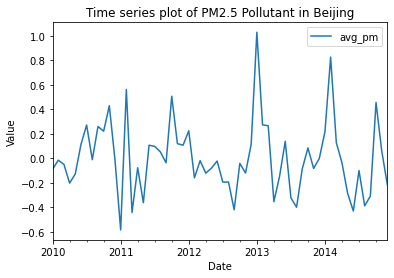

In [12]:
## Plotting the Time Series Plot of PM2.5 Pollutant 
def plot_ts(ts, lab = ''):
    ts.plot()
    plt.title('Time series plot of ' + lab)
    plt.ylabel('Value')
    plt.xlabel('Date')
    
plot_ts(pm_df, 'PM2.5 Pollutant in Beijing')

#### Time Series Plot Analysis

The time series plot has a slightly consistent trend over the years, and there does appear to be a seasonal component to the data. However we see that there are larger increases in 2013 and 2014 - and pm2.5 levels get above 160. 

Since there is not an overall upward trend over time, I will use an additive decomposition model.

This time series is not stationary since the variance does appear to vary over time. 

In [13]:
## Defining Decomposition Function 
def decomp_ts(ts, freq = 'M', model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model)
    res.plot()
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                       index = ts.index) )

               resid     trend  seasonal
Date                                    
2010-01-01       NaN       NaN  0.196675
2010-02-01       NaN       NaN  0.358473
2010-03-01       NaN       NaN -0.023908
2010-04-01       NaN       NaN -0.150466
2010-05-01       NaN       NaN -0.220976
2010-06-01       NaN       NaN -0.047797
2010-07-01  0.279106  0.045059 -0.052195
2010-08-01  0.105583  0.048470 -0.165039
2010-09-01  0.311970  0.056123 -0.108477
2010-10-01  0.025015  0.044976  0.151295
2010-11-01  0.343830  0.040440  0.044927
2010-12-01 -0.061821  0.030430  0.017487
2011-01-01 -0.803206  0.022910  0.196675
2011-02-01  0.185003  0.018269  0.358473
2011-03-01 -0.426765  0.008575 -0.023908
2011-04-01  0.065998  0.008125 -0.150466
2011-05-01 -0.147803  0.007108 -0.220976
2011-06-01  0.155569 -0.000724 -0.047797
2011-07-01  0.111497  0.038026 -0.052195
2011-08-01  0.175618  0.041690 -0.165039
2011-09-01  0.042891  0.029294 -0.108477
2011-10-01  0.310012  0.045078  0.151295
2011-11-01  0.01

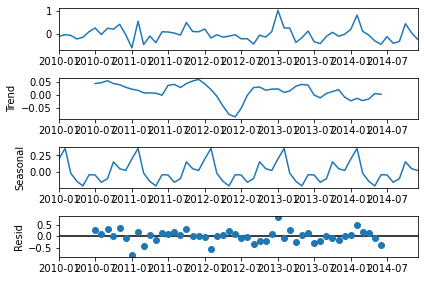

In [14]:
## Applying the Decomposition function to the FULL PM2.5 Dataset: 
pm_decomp = decomp_ts(pm_df)

print(pm_decomp)


The decomposition results of the monthly averaged data looks appropriate. I see that the seasonal trend is much more discernable and clear enough to read! It is also regularly occuring between 25 and -25. 

The trend plot does have irregular peaks throughout the month, as some peaks are larger than others. There's also a large decrease in the trend around mid-2012.

It is also important to note that the residual and trend columns have NaN values in the first and last 6 rows of the data frame since it's a monthly time series. We will separate these out when applying the Dicky Fuller test. 


In [15]:
## Conducting the Dicky Fuller Test

# Declaring the Function 
def DF_Test(ts):
    stationary = adfuller(ts)
    ## Print the results
    print('D-F statistic = ' + str(stationary[0]))
    print('p-value = ' + str(stationary[1]))
    print('number of lags used = ' + str(stationary[2]))
    print('Critical value at 5% confidence = ' + str(stationary[4]['5%']))
    print('Critical value at 10% confidence = ' + str(stationary[4]['10%']))
    
## Applying the Test to the decomposition residuals 
DF_Test(pm_decomp.resid[6:-6])    

D-F statistic = -4.828646859513701
p-value = 4.7923344018877826e-05
number of lags used = 3
Critical value at 5% confidence = -2.929885661157025
Critical value at 10% confidence = -2.6031845661157025


Given that there is a large DF statistic and that the p-value is small (< 0.05), we can reject the null hypothesis that the residual is not stationary. We also know that this is not due to random chance since that confidence interval does not straddle 0.

### Using the auto_arima function from the pmdarima package to find a best model fit, excluding the last 12 months of observations from the training data, and setting d=1 and D=1 and limit p, q, P and Q to 3 with starting values of 1.

Up to this point, the following changes I have made compared to the data processing in Milestone 3 include: creating a new pm2.5 monthly average value, changing the frequency of the timeseries from hourly to monthly. 

Below, I will fine tune additional parameters for the Auto Arima model. According to the documentation of the auto_arima function (https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html), there are various optimizer names that can be passed to the method parameter. I have gone through and tested each method and documented below which method produced the lowers AIC score. 

In [16]:
import pmdarima as pm
from pmdarima.arima import auto_arima

## Applying the Auto_arima function
stepwise_fit = auto_arima(pm_df.avg_pm, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             method = 'nm', # instead of lbfgs
                             information_criterion = 'aic',
                             error_action='ignore',  # ignoring if an order does not work
                             suppress_warnings=True,  # removing convergence warnings
                             stepwise=True,   # set to stepwise
                             random_state = 10)

## Printing Summary & Best AIC value
print(stepwise_fit.summary())

print("Best AIC Value: ", stepwise_fit.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=80.880, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=57.862, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=59.211, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=46.010, Time=0.49 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=48.425, Time=0.42 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=61.811, Time=0.16 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=56.848, Time=0.34 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=46.376, Time=0.62 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=46.160, Time=0.49 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=38.763, Time=0.37 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=45.719, Time=0.17 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=42.275, Time=0.54 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=

### Summary Review

When previously conducting this analysis, the Auto_arima function with default parameters displayed that ARIMA(1,1,0)(2,1,0)[12] was the best model and it had an AIC value of AIC=47.311.
All of the model coeffients were statistically significant, and the p-values were less than 0.05 and the confidence intervals did not contain zero (aside from sigma2).

I went through the various optimization methods I could pass to the model and documented the AIC score and model produced (if applicable). 

- method = 'nm' ->  Best AIC 42.142 -->  ARIMA(0,1,1)(2,1,0)[12]

- method = 'powell' and method = 'bfgs' gave same results as 'lbfgs' (the default parameter) 

- method = 'cg' --> best AIC AIC=68.496 --> ARIMA(0,1,1)(0,1,0)[12] 

- method = 'ncg' errored out 

- method = 'basinhopping' took too long to run 

The two methods that caught my eye were 'nm' or newton, and 'cg' or conjugate gradient, since they both had an AIC value that was less than the default parameter 'lbfgs'. I chose to continue with the newton method since that AIC was the lowest and all the coeffients were statistically significant and had a p-value < 0.05. 

Below, I will split the data into training and testing data. I have also adjusted the dates, so the training dataset now contains 3 years (as opposed to 4 last time) and the testing data contains 2 years worth of data (as opposed to 1). 

In [24]:
## Splitting Test and Training Data 
train = pm_df[:-24]  ## Training Data
test = pm_df[-24:] ## Testing  Data


print(train) # 2010 - 2012 Data Values
print(test) # 2013 - 2014 Year Data Values

              avg_pm
Date                
2010-01-01 -0.088764
2010-02-01 -0.014984
2010-03-01 -0.049029
2010-04-01 -0.201891
2010-05-01 -0.127254
2010-06-01  0.112878
2010-07-01  0.271970
2010-08-01 -0.010985
2010-09-01  0.259616
2010-10-01  0.221287
2010-11-01  0.429197
2010-12-01 -0.013904
2011-01-01 -0.583620
2011-02-01  0.561745
2011-03-01 -0.442098
2011-04-01 -0.076344
2011-05-01 -0.361671
2011-06-01  0.107048
2011-07-01  0.097328
2011-08-01  0.052269
2011-09-01 -0.036292
2011-10-01  0.506386
2011-11-01  0.119707
2011-12-01  0.107620
2012-01-01  0.224849
2012-02-01 -0.158786
2012-03-01 -0.019082
2012-04-01 -0.120527
2012-05-01 -0.079658
2012-06-01 -0.021914
2012-07-01 -0.194077
2012-08-01 -0.192810
2012-09-01 -0.419469
2012-10-01 -0.041000
2012-11-01 -0.120124
2012-12-01  0.114980
              avg_pm
Date                
2013-01-01  1.028364
2013-02-01  0.273642
2013-03-01  0.265637
2013-04-01 -0.353071
2013-05-01 -0.146531
2013-06-01  0.139091
2013-07-01 -0.321887
2013-08-01 -0

In [25]:
## Fitting the Model with the Training Dataset 
stepwise_fit.fit(train)

## Using the Model to predict the values of the Test Dataset
predictions, CI = stepwise_fit.predict(n_periods=test.shape[0], return_conf_int = True)



In [26]:
print(predictions)
print(test)

[ 0.18833645 -0.10923831 -0.03693213 -0.10863695 -0.08849417 -0.00868903
 -0.17680101 -0.17327108 -0.40037048 -0.00426572 -0.10752889  0.12454759
  0.21219427 -0.11668207 -0.02083287 -0.10225253 -0.07532858 -0.00389014
 -0.17510533 -0.17083966 -0.40040759 -0.00803094 -0.10469975  0.13196197]
              avg_pm
Date                
2013-01-01  1.028364
2013-02-01  0.273642
2013-03-01  0.265637
2013-04-01 -0.353071
2013-05-01 -0.146531
2013-06-01  0.139091
2013-07-01 -0.321887
2013-08-01 -0.398762
2013-09-01 -0.085450
2013-10-01  0.085121
2013-11-01 -0.082209
2013-12-01 -0.001110
2014-01-01  0.216671
2014-02-01  0.825689
2014-03-01  0.128981
2014-04-01 -0.036723
2014-05-01 -0.286352
2014-06-01 -0.429452
2014-07-01 -0.099483
2014-08-01 -0.387515
2014-09-01 -0.307656
2014-10-01  0.455654
2014-11-01  0.062629
2014-12-01 -0.216897


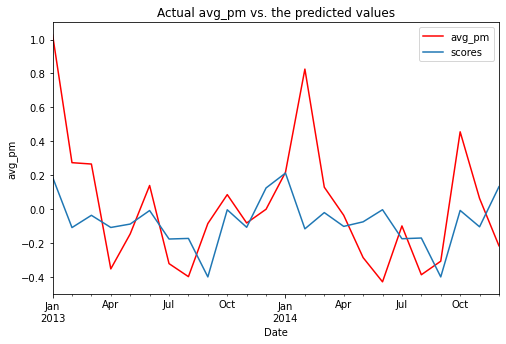

In [27]:
def plot_mod_fit(df, col):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(8, 5)) # set plot area
    ax = fig.gca() # define axis  
    df.loc[:, col].plot(color = 'r', ax = ax)
    df.loc[:, 'scores'].plot(ax = ax) 
    ax.set_title('Actual ' + col + ' vs. the predicted values') # Give the plot a main title
    ax.set_xlabel('Date') # Set text for the x axis
    ax.set_ylabel(col)# Set text for y axis
    ax.legend()
    
## Adding the Scores Column 
predictions = pd.DataFrame(predictions, index = test.index,
                               columns=['scores'])
predictions = pd.concat([test, predictions],axis=1)

## Adding a Residual Column 
predictions.loc[:, "residual"] = predictions.loc[:, "scores"] - predictions.loc[:, "avg_pm"]


## Plotting Prediction vs Actual Values 
plot_mod_fit(predictions, 'avg_pm')

These predictions are close to the actual observations. The two lines in the plot above do not overlap on some parts (March to November, for example) however the difference between the values are not drastically different. The best way to check how close the actual observations are to the predictions is relying on the RMSE.

In [28]:
def RMSE(ts, score):
    from math import sqrt
    return sqrt(np.std(ts - score))

RMSE(predictions.loc[:, "avg_pm"], predictions.loc[:, "scores"])



0.5744357655214649

This new model has a root mean square error (RMSE) of .574 which is a good improvement! Before making any auto arima model adjustments, the RMSE was 0.78. 

**Note, in Milestone 3 the RMSE was 4.786 which is no longer comparable since I have now scaled and averaged the pm2.5 column. Thus, I calculated the RMSE after making the changes to the pm2.5 column and before I tweaked the auto arima model. 

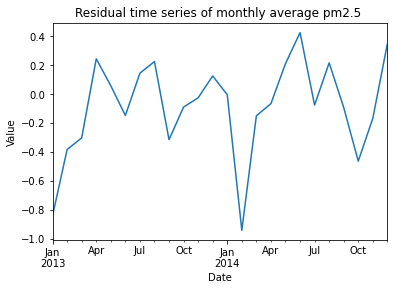

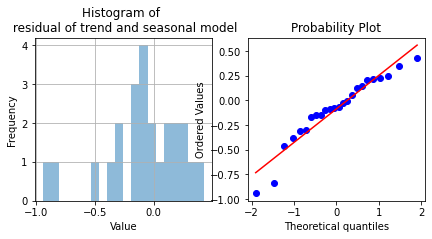

In [29]:
def dist_ts(ts, lab = '', bins = 20):
    import scipy.stats as ss
    ## Setup a figure with two subplots side by side
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ## Plot the histogram with labels
    ts.hist(ax = ax1, bins = bins, alpha = 0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histogram of ' + lab)
    ## Plot the q-q plot on the other axes
    ss.probplot(ts, plot = ax2)
    
def plot_ts(ts, title):
    ts.plot()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    
    
    
plot_ts(predictions.loc[:, 'residual'],  
        title = 'Residual time series of monthly average pm2.5 ' )

dist_ts(predictions.loc[:, 'residual'], 
        '\n residual of trend and seasonal model')

The time series of the residual does show slight periodic behaivor. The histogram of the residual data does appear to be normally distributed (and slightly skewed to the left) , and the probability plot does appear to fall some what close to the red line. These residuals do appear to be more normally distributed than the milestone 3 assignment residuals. 


In [30]:
print("Confidence Intervals for the Predictions in 2013: ")
print(CI)

print("\n")

print("Mean for the Forecast/Predictions: ")
print(np.mean(predictions))

Confidence Intervals for the Predictions in 2013: 
[[-0.99778855  1.37446145]
 [-1.74921497  1.53073835]
 [-2.02995856  1.95609431]
 [-2.40096879  2.1836949 ]
 [-2.64533132  2.46834298]
 [-2.80512375  2.78774569]
 [-3.19386549  2.84026347]
 [-3.39589563  3.04935347]
 [-3.81620712  3.01546615]
 [-3.60295587  3.59442444]
 [-3.88022047  3.66516269]
 [-3.81446658  4.06356177]
 [-4.33258239  4.75697093]
 [-5.17276397  4.93939983]
 [-5.54106234  5.4993966 ]
 [-6.05052141  5.84601635]
 [-6.42283769  6.27218054]
 [-6.72697286  6.71919257]
 [-7.25386302  6.90365237]
 [-7.58823677  7.24655744]
 [-8.14164451  7.34082933]
 [-8.06009392  8.04403205]
 [-8.45602825  8.24662874]
 [-8.5082728   8.77219674]]


Mean for the Forecast/Predictions: 
avg_pm      0.013683
scores     -0.072302
residual   -0.085985
dtype: float64


The confidence interval ranges fluctuate a lot and can be large at times. 

### Conclusions 

The purpose of this assignment was to revisit a previous model we generated, and to adjust and/or apply data enhancement techniques. For this time series model, I continued to work with the auto_arima model to forecast pm2.5 pollutant data in Beijing. Some of the adjustments I made included: using the average pm2.5 values, changing the frequency of the timeseries to monthly instead of hourly, specified the "newton" method of optimization for the model, and trained the model on 3 years of data instead ofo 4.

All in all this yielded positive results, and improved the forecasting done by the model. The model's predictions had a root mean square error (RMSE) of .574 - which is approximately and improvement of 0.21. The residuals also appeared to be more normally distributed than the first attempt of the model.

I believe this model could be utilized at an organization to understand the time based fluctuations of the pm2.5 pollutant in Beijing, and make relatively close estimates to what the pm2.5 pollution rates may be like in the future. 
